In [1]:
import statsmodels.api as sm
import numpy as np
from scipy.optimize import minimize
from tabulate import tabulate
from numpy import linalg as la
import time
import pandas as pd
import mestim as M
from discrete_choice import * 
import matplotlib.pyplot as plt
import LinearModelsWeek3_post as lm

from numpy import random
from scipy.stats import genextreme


## Data

In [2]:
df_overview = pd.read_csv('Overview.csv')
df_overview.sort_values(by=['Count'], ascending=True, inplace=True) 
df_overview.tail(5)
print(df_overview.columns)

df_overview = pd.read_csv('Overview.csv')
df_overview = df_overview.rename(columns={'Fast charge (min)': 'ChargeTime'})
unique_types = df_overview['Type'].unique()
for i in unique_types:
    df_overview[i] = np.where(df_overview['Type'] == i, 1, 0)


unique_Country = df_overview['Country'].unique()

unique_segments = df_overview['Segment'].unique()
for i in unique_segments:
    df_overview[i] = np.where(df_overview['Segment'] == i, 1, 0)
print(f'segments : {unique_segments} \n Countrys : {unique_Country} \n types : {unique_types}')


#Europa, Kina, USA, Andet
df_overview['Europe'] = np.where((df_overview['Country'] != 'US') & (df_overview['Country'] != 'CH') & (df_overview['Country'] != 'JP') & (df_overview['Country'] != 'KR'), 1, 0)
df_overview['China'] = np.where(df_overview['Country'] == 'CH', 1, 0)
df_overview['USA'] = np.where(df_overview['Country'] == 'US', 1, 0)
df_overview['Other'] = np.where((df_overview['Europe'] != 1) & (df_overview['China'] != 1) & (df_overview['USA'] != 1), 1, 0)

df_overview.head(5)
#df_overview[df_overview['Manufacturer'] == 'Nissan']


Index(['ID', 'Manufacturer', 'Model', 'Range', 'Price', 'HP',
       'Fast charge (min)', 'Type', 'Segment', 'Country', 'Count', 'Share',
       'Percentage'],
      dtype='object')
segments : ['C' 'F' 'E' 'B' 'D' 'M' 'A' 'J'] 
 Countrys : ['CH' 'DE' 'FR' 'SP' 'RO' 'IT' 'DK' 'US' 'JP' 'KR' 'GB' 'SE' 'CZ'] 
 types : ['SUV' 'Sedan' 'Hatchback' 'MPV' 'Stationcar' 'Cabriolet' 'Liftback']


,ID,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,Segment,Country,...,E,B,D,M,A,J,Europe,China,USA,Other
0,1,Aiways,U5,400,3.308258e+05,201,34,SUV,C,CH,...,0,0,0,0,0,0,0,1,0,0
1,2,Aiways,U6,405,3.757100e+05,214,34,SUV,C,CH,...,0,0,0,0,0,0,0,1,0,0
2,3,Audi,e-tron,375,7.149530e+05,402,17,SUV,F,DE,...,0,0,0,0,0,0,1,0,0,0
3,4,Audi,e-tron GT,472,1.081416e+06,522,17,Sedan,F,DE,...,0,0,0,0,0,0,1,0,0,0
4,5,Audi,Q4 e-tron,496,4.547246e+05,281,28,SUV,C,DE,...,0,0,0,0,0,0,1,0,0,0


In [3]:
df_dataset = pd.read_csv('Dataset.csv')
df_dataset = df_dataset.rename(columns={'Fast charge (min)': 'ChargeTime'})
unique_types = df_dataset['Type'].unique()
#print(df_dataset.columns)
for i in unique_types:
    df_dataset[i] = np.where(df_dataset['Type'] == i, 1, 0)


years = df_dataset['year'].unique()

unique_Country = df_dataset['Country'].unique()

unique_segments = df_dataset['Segment'].unique()
for i in unique_segments:
    df_dataset[i] = np.where(df_dataset['Segment'] == i, 1, 0)
#print(f'segments : {unique_segments} \n Countrys : {unique_Country} \n types : {unique_types}')


#Europa, Kina, USA, Andet
df_dataset['Europe'] = np.where((df_dataset['Country'] != 'US') & (df_dataset['Country'] != 'CH') & (df_dataset['Country'] != 'JP') & (df_dataset['Country'] != 'KR'), 1, 0)
df_dataset['China'] = np.where(df_dataset['Country'] == 'CH', 1, 0)
df_dataset['USA'] = np.where(df_dataset['Country'] == 'US', 1, 0)
df_dataset['Other'] = np.where((df_dataset['Europe'] != 1) & (df_dataset['China'] != 1) & (df_dataset['USA'] != 1), 1, 0)
print(df_dataset.head(1))


df_dataset_ms0 = df_dataset[df_dataset['Market share'] != 0]
df_dataset_ms0.sort_values(by=['Market share'], ascending=False, inplace=True)
#print(df_dataset_ms0.sample(1))

df_dataset_year_ms0 = {}
for year in years:
    df_dataset_year_ms0[year] = df_dataset_ms0[df_dataset_ms0['year'] == year]




   ID  year  Market share Manufacturer Model  Range  Price   HP  ChargeTime  \
0   1  2013           0.0       Aiways    U5    400    0.0  201          34   

  Type  ...  E  B  D  M  A  J  Europe  China  USA  Other  
0  SUV  ...  0  0  0  0  0  0       0      1    0      0  

[1 rows x 31 columns]


/var/folders/84/nl1t_q050914klynvps92vkc0000gn/T/ipykernel_90665/3974771862.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset_ms0.sort_values(by=['Market share'], ascending=False, inplace=True)


In [4]:
df_dataset.head(11)
#df.info()

,ID,year,Market share,Manufacturer,Model,Range,Price,HP,ChargeTime,Type,...,E,B,D,M,A,J,Europe,China,USA,Other
0,1,2013,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
1,1,2014,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
2,1,2015,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
3,1,2016,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
4,1,2017,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
5,1,2018,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
6,1,2019,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
7,1,2020,0.000000,Aiways,U5,400,0.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
8,1,2021,0.010319,Aiways,U5,400,284622.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0
9,1,2022,0.005938,Aiways,U5,400,313682.0,201,34,SUV,...,0,0,0,0,0,0,0,1,0,0


## Grafer

In [5]:
Country_shares = {
    'Europe': [],
    'China': [],
    'USA': [],
    'Other': []
}
#& (df_dataset['Market share'] != 0)
for Country in Country_shares.keys():
    for year in years:
        Country_df = df_dataset[(df_dataset[Country] == 1) & (df_dataset['year'] == year)]
        if not Country_df.empty:
            Country_shares[Country].append(Country_df['Market share'].sum())
#print(Country_shares)




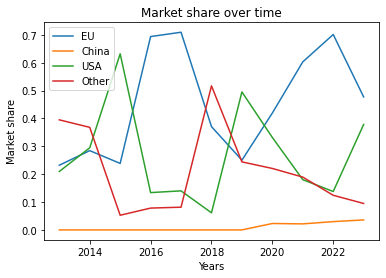

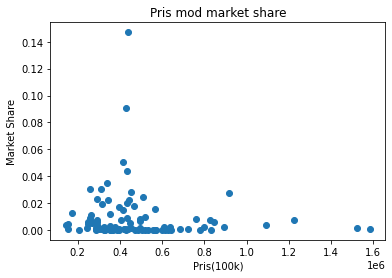

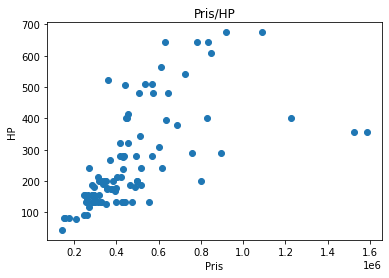

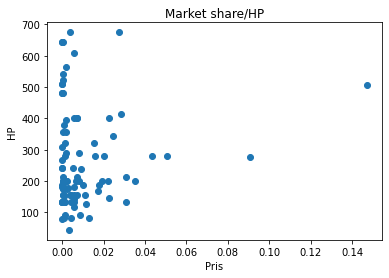

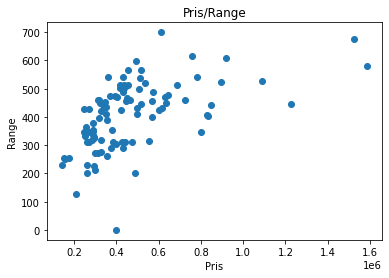

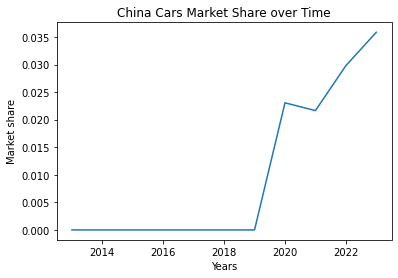

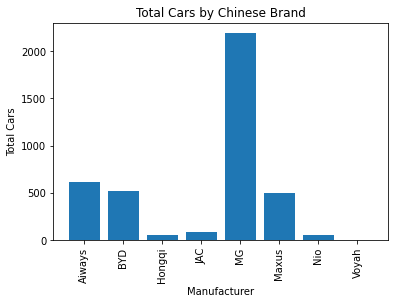

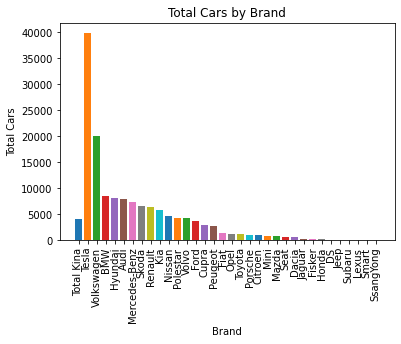

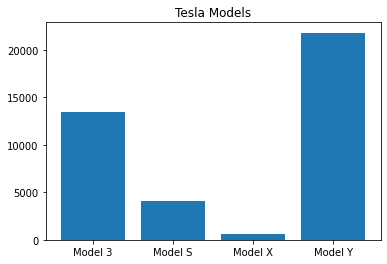

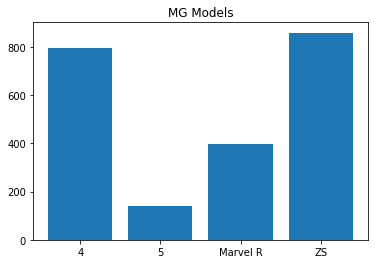

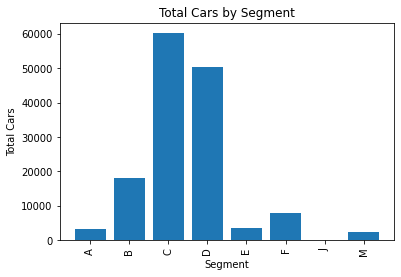

In [6]:
#Market share over time
#plt.figure(figsize=(12, 6))
for Country in Country_shares.keys():
    plt.plot(years, Country_shares[Country])
plt.legend(['EU', 'China', 'USA', 'Other'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('Market share over time')
plt.show()

#Pris mod market share
# x = pris, y = Count
#plt.scatter(x,y)
#Kun for de 5 med højest Count
mængde = 100
# Pris/Market Share
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.Share[len(df_overview)-mængde:])
plt.title('Pris mod market share')
plt.xlabel('Pris(100k)')
plt.ylabel('Market Share')
plt.show()

# Pris/HP
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.HP[len(df_overview)-mængde:])
plt.title('Pris/HP')
plt.xlabel('Pris')
plt.ylabel('HP')
plt.show()

# Market share/HP
plt.scatter(df_overview.Share[len(df_overview)-mængde:], df_overview.HP[len(df_overview)-mængde:])
plt.title('Market share/HP')
plt.xlabel('Pris')
plt.ylabel('HP')
plt.show()

#Pris/Range
plt.scatter(df_overview.Price[len(df_overview)-mængde:], df_overview.Range[len(df_overview)-mængde:])
plt.title('Pris/Range')
plt.xlabel('Pris')
plt.ylabel('Range')
plt.show()

#Market share over time
plt.plot(years, Country_shares['China'])
plt.xlabel('Years')
plt.ylabel('Market share')
plt.title('China Cars Market Share over Time')
plt.show()

#Total Cars by Chinese Brand
df_china = df_overview[df_overview['China'] == 1]
brand_totals = df_china.groupby('Manufacturer')['Count'].sum()

plt.bar(brand_totals.index, brand_totals.values)
plt.title('Total Cars by Chinese Brand')
plt.xlabel('Manufacturer')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()

#Kinesere by brands
df_china = df_overview[df_overview['China'] == 1]

total_kina = df_china['Count'].sum() #Alle kinesere (samlet)
plt.bar('Total Kina', total_kina)
plt.title('Total Cars by Chinese Brands')


#Alle ikke CH-brands mod total CH. 
df_not_china = df_overview[df_overview['China'] == 0]
not_china_totals = df_not_china.groupby('Manufacturer')['Count'].sum() #Alle ikke kinesere(unikke)
sorted_not_china_totals = not_china_totals.sort_values(ascending=False)

for i, (brand, total) in enumerate(sorted_not_china_totals.items()):
    plt.bar(brand, total, label=brand)

plt.title('Total Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()

#Tesla models (Største i EU)
df_tesla = df_overview[df_overview['Manufacturer'] == 'Tesla']
df_tesla = df_tesla.groupby('Model')['Count'].sum()
plt.bar(df_tesla.index, df_tesla.values)
plt.title('Tesla Models')
plt.show()

#MG (største kinesiske mærke i DK)
df_mg = df_overview[df_overview['Manufacturer'] == 'MG']
df_mg = df_mg.groupby('Model')['Count'].sum()
plt.bar(df_mg.index, df_mg.values)
plt.title('MG Models')
plt.show()

#Cars by segment
segment_totals = df_overview.groupby('Segment')['Count'].sum()
plt.bar(segment_totals.index, segment_totals.values)
plt.title('Total Cars by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Cars')
plt.xticks(rotation=90)
plt.show()




# Estimering

In [7]:
label_y = 'Market share'
label_x = ['Range', 'Price', 'HP', 'ChargeTime', 'China']
data_scaled = df_dataset
data_scaled['Range'] = data_scaled['Range'] / 100
data_scaled['Price'] = data_scaled['Price'] / 100000
data_scaled['HP'] = data_scaled['HP'] / 100
data_scaled['ChargeTime'] = data_scaled['ChargeTime'] / 100

# Standard OLS

In [8]:
#Bruger data hvor ms = 0 er inkluderet
data = df_dataset
N = data['ID'].unique().size
N
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

Data has N=110 and T=11 data is = 1210, 1210


In [9]:
#Bruger data hvor ms = 0 er inkluderet
N
y = df_dataset['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = df_dataset['Range'].values.reshape((N*T,1)) #1
Price = df_dataset['Price'].values.reshape((N*T,1)) #2
HP = df_dataset['HP'].values.reshape((N*T,1)) #3
ChargeTime = df_dataset['ChargeTime'].values.reshape((N*T,1))  #4
China = df_dataset['China'].values.reshape((N*T,1)) #5

### Forklarende variable: attributes og pris

In [10]:
Nobs=df_dataset['ID'].count()
df['const']=np.ones((Nobs,1))
# Define dependent and explanatory variables
X = df_dataset[['Range', 'Price', 'HP', 'ChargeTime', 'const']]
y = df_dataset['Market share']

# Fit logistic regression model
OLS_model = sm.OLS(y, X)
result = OLS_model.fit()

# Print summary of the regression results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     12.12
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           1.16e-09
Time:                        14:36:21   Log-Likelihood:                 2120.8
No. Observations:                1210   AIC:                            -4232.
Df Residuals:                    1205   BIC:                            -4206.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Range          0.0023      0.001      1.580      0.1

### Forklarende variable: attributes, pris og kina

In [11]:
# Define dependent and explanatory variables
X = df_dataset[['Range', 'Price', 'HP', 'ChargeTime', 'const', 'China']]
y = df_dataset['Market share']

# Fit logistic regression model
OLS_model = sm.OLS(y, X)
result = OLS_model.fit()

# Print summary of the regression results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     12.01
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           2.28e-11
Time:                        14:36:22   Log-Likelihood:                 2126.3
No. Observations:                1210   AIC:                            -4241.
Df Residuals:                    1204   BIC:                            -4210.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Range          0.0024      0.001      1.637      0.1

### Market share = 0 i 2023 ekskluderet

In [12]:
#Bruger data hvor market share = 0 er ekskluderet
data = df_dataset_year_ms0[2023]

N = data['ID'].unique().size
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

Data has N=102 and T=1 data is = 102, 102


In [13]:
y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = data['Range'].values.reshape((N*T,1)) #1
Price = data['Price'].values.reshape((N*T,1)) #2
HP = data['HP'].values.reshape((N*T,1)) #3
ChargeTime = data['ChargeTime'].values.reshape((N*T,1))  #4
China = data['China'].values.reshape((N*T,1)) #5


In [17]:
Nobs=data['ID'].count()
data['const']=np.ones((Nobs,1))
# Define dependent and explanatory variables
X = data[['Range', 'Price', 'HP', 'ChargeTime', 'const', 'China']]
y = data['Market share']

# Fit logistic regression model
OLS_model = sm.OLS(y, X)
result = OLS_model.fit()

# Print summary of the regression results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           Market share   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.419
Date:                Tue, 20 Feb 2024   Prob (F-statistic):              0.224
Time:                        14:37:21   Log-Likelihood:                 217.42
No. Observations:                 102   AIC:                            -422.8
Df Residuals:                      96   BIC:                            -407.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Range       3.662e-05   3.59e-05      1.019      0.3

/var/folders/84/nl1t_q050914klynvps92vkc0000gn/T/ipykernel_90665/401416439.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['const']=np.ones((Nobs,1))


## Logit

In [19]:
#Estimere full sample med logit
data = df_dataset
N = data['ID'].unique().size
#print("market share value :", df['Market share'].size)
T = data['year'].unique().size
assert data.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T} data is = {data.shape[0]}, {N*T}')

Data has N=110 and T=11 data is = 1210, 1210


### Forklarende variable: attributes og pris

In [20]:
# Sample data generation

y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = data['Range'].values.reshape((N*T,1)) #1
Price = data['Price'].values.reshape((N*T,1)) #2
HP = data['HP'].values.reshape((N*T,1)) #3
ChargeTime = data['ChargeTime'].values.reshape((N*T,1))  #4
China = data['China'].values.reshape((N*T,1)) #5
X = np.hstack([ones, Range, Price, HP, ChargeTime])


# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit(cov_type = 'HC3')

# Display results
print(result.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime'], yname='Market share'))


Optimization terminated successfully.
         Current function value: 0.013368
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           Market share   No. Observations:                 1210
Model:                          Logit   Df Residuals:                     1205
Method:                           MLE   Df Model:                            4
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                  -2.126
Time:                        14:41:13   Log-Likelihood:                -16.176
converged:                       True   LL-Null:                       -5.1738
Covariance Type:                  HC3   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.3713      0.596    -10.689      0.000      -7.540      -5.203
Range          0.2304      0.

### Forklarende variable: attributes, pris og kina

In [21]:
# Sample data generation

y = data['Market share'].values.reshape((N*T,1))
ones = np.ones((N*T,1))
Range = data['Range'].values.reshape((N*T,1)) #1
Price = data['Price'].values.reshape((N*T,1)) #2
HP = data['HP'].values.reshape((N*T,1)) #3
ChargeTime = data['ChargeTime'].values.reshape((N*T,1))  #4
China = data['China'].values.reshape((N*T,1)) #5
X = np.hstack([ones, Range, Price, HP, ChargeTime, China])


# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit(cov_type = 'HC3')

# Display results
print(result.summary(xname=['const', 'Range', 'Price', 'HP', 'ChargeTime', 'China'], yname='Market share'))

Optimization terminated successfully.
         Current function value: 0.013430
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:           Market share   No. Observations:                 1210
Model:                          Logit   Df Residuals:                     1204
Method:                           MLE   Df Model:                            5
Date:                Tue, 20 Feb 2024   Pseudo R-squ.:                  -2.141
Time:                        14:41:35   Log-Likelihood:                -16.251
converged:                       True   LL-Null:                       -5.1738
Covariance Type:                  HC3   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5420      0.547    -11.966      0.000      -7.613      -5.470
Range          0.2282      0

## Conditional Logit

In [22]:

data = df_dataset
T = data['year'].unique().size
M = data['Model'].unique().size
#print(f'df {data.head(1)}, {data.shape}')

data = np.array(data[['Market share', 'Range', 'Price', 'HP', 'ChargeTime', 'China']])
#print(f'\n \n data: {data[:2]} \n shape {data.shape[1]}')
V = data.shape[1] - 1

y = data[:,0].reshape(M,1, T) #reshape for column vector
#print(f' \n \n y: {y[:2]} \n shape {y.shape}')

x = data[:,1:].reshape(M, V, T)
#print(f' \n \n x: {x[:2]} \n shape {x.shape}')

print(f' \n \n y shape {y.shape} \n \n x shape {x.shape}')

 
 
 y shape (110, 1, 11) 
 
 x shape (110, 5, 11)


In [23]:
def clogit(y, x, cov_type='Ainv', theta0=None, deriv=0, quiet=False): 
	# Objective function and derivatives for 
    M, V, T, palt, xalt, xvars = labels(x)

    Qfun     = lambda theta, out:  Q_clogit(theta, y, x, out)

    if theta0 is None: 
        theta0=np.zeros((T,1))

    res = estimation(Qfun, theta0, deriv, cov_type, parnames=xvars)
    #res.update(dict(zip(['yvar', 'xvars', 'Model','Tid', 'n'], ['y', xvars, M, V, M])))

    #if quiet==False:
    #    print('Conditional logit')
    #    print('Initial log-likelihood', -Qfun(theta0, 'Q'))
    #    print('Initial gradient\n', -Qfun(theta0, 'dQ'))
    #    print_output(res)

    #return res  




In [24]:
def labels(x):
    # labels and dimensions for plotting
    M, V, T = x.shape
    palt=['p' + str(i)  for i in range(V)]
    xalt=['alt' + str(i)  for i in range(V)]
    xvars=['var' + str(i)  for i in range(T)]
    return M, V, T, palt, xalt, xvars

In [25]:
def Q_clogit(theta, y, x, out='Q'):
    #N, J, K = x.shape
    M, V, T = x.shape
    
    #def utiliy(theta, x):
    #   u = x @ theta
	#   return u.reshape(N,V) 
    
    v = utiliy(theta, x) # v = x @ theta 	# Deterministic component of utility
    ll_i=logccp(v, y) 
    q_i= - ll_i   
    if out=='Q':
    	return np.mean(q_i)
    
    #Hvad bruger man de andre ting til?

    #dv=x
    #p=ccp(v)
    #if out=='predict':  return v, p, dv         # Return predicted values
    #N, J, K = dv.shape
    #idx=y[:,] + J*np.arange(0, N)
    #dvj=dv.reshape(N*J, K)[idx,:] 	# pick choice specific values corresponding to y 

    #s_i = dvj -  np.sum(p.reshape(N,J,1)*dv, axis=1)
    #g = -np.mean(s_i, axis=0)
    
    #if out=='s_i': return s_i                     # Return s_i: NxK array with scores
    #if out=='dQ':  return g;  # Return dQ: array of size K derivative of sample objective function


In [26]:
def logccp(v, y=None, sigma=1):
    # Log of conditional choice probabilities 
    # If y = None return logccp corresponding to all choices
    # if y is Nx1 vector of choice indexes, return likelihood
    ev = logsum(v, sigma) 	# Expected utility (always larger than V) For hvert alternativ?
    if y is not None:	
    	N, J=v.shape
    	idx=y[:,] + J*np.arange(0, N)
    	v=v.reshape(N*J, 1)[idx] 	# pick choice specific values corresponding to y 
    return (v - ev)/sigma

In [27]:
def logsum(v, sigma=1): # Maximal expected utility - the "log-sum"
	# Expected max over iid extreme value shocks with scale parameter sigma
	# Logsum is reentered around maximum to obtain numerical stability (avoids overflow, but accepts underflow)
	max_v = v.max(axis=1).reshape(-1, 1) #max_v = største værdi i hver række og derfor valget (y) uden støj.
	return max_v + sigma*np.log(np.sum(np.exp((v-max_v)/sigma), 1)).reshape(-1, 1)

In [28]:
def estimation(Qfun, theta0, deriv=0, cov_type ='sandwich', parnames='', output=False): 

    tic = time.perf_counter()
    
    # Q: Sample objective function to minimize (e.g. sample average of negative log-livelihood)
    Q = lambda theta:  Qfun(theta, out='Q')

    # dQ: Derivative of sample objective function wrt parameters theta (function returns size K array)
    dQ = None
    if deriv>0: # use user-supplied 1 order derivatives
        dQ = lambda theta:  Qfun(theta, out='dQ')

    hess = None
    if deriv>1: # use user-supplied 2 order derivatives
        hess  =  lambda theta:  Qfun(theta, out='H')
        result=minimize(fun=Q, jac=dQ, hess=hess, x0=theta0, method='trust-ncg')
        result.hess_inv=la.inv(result.hess)
    else: # use bfgs
        result=minimize(fun=Q, jac=dQ, x0=theta0, method='bfgs')
    
    theta_hat=np.array(result.x).reshape(-1,1)
    
    toc = time.perf_counter()

    # variance co-variance matrix
    s_i=Qfun(theta_hat, out='s_i')

    cov = avar(s_i, result.hess_inv, cov_type)
    se = np.sqrt(np.diag(cov)).reshape(-1, 1)

    # collect output
    names =   ['parnames', 'theta_hat', 'se',  't-values',  'cov', 'Q', 'time', 's_i']
    results = [parnames, theta_hat, se, theta_hat/se, cov, Q(theta_hat), toc - tic, s_i]

    result.update(dict(zip(names, results)))

    if output: 
        if result.parnames: 
            table=({k:result[k] for k in ['parnames', 'theta_hat', 'se', 't-values', 'jac']})
        else: 
            table=({k:result[k] for k in ['theta_hat', 'se', 't-values', 'jac']})
        print(tabulate(table, headers="keys",floatfmt="10.5f"))
        print('')
        print(result.message)
        print('Objective function:', result['Q'])
        print ('Iteration info: %d iterations, %d evaluations of objective, and %d evaluations of gradients' 
            % (result.nit,result.nfev, result.njev))
        print(f"Elapsed time: {result['time']:0.4f} seconds")

    return result

In [29]:
clogit(y, x, cov_type='Ainv',theta0=None, deriv=0, quiet=False)

ValueError: operands could not be broadcast together with shapes (110,1,11) (110,) 